In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import sklearn
from tqdm import tqdm

In [2]:
def my_processing(dataset, outsize, pre_type='his'):
    
    data = []
    
    for timestep in tqdm(dataset):                                        #image to crop
        seg = []
        for img in timestep:

            rect_mask = np.zeros(img.shape[:2], dtype="uint8")           #black mask with shape of spectrogram 
            cv2.rectangle(rect_mask,(79,57),(576,427),255,-1)              #fill area we want to keep with white

            masked_img = cv2.bitwise_and(img, img, mask=rect_mask)   #apply


            output_img = masked_img[57:427,79:576]                    #resize image to fit in model
            output_img = cv2.resize(output_img, (outsize,outsize))

            if pre_type == 'his':
                output_img = pre_his(output_img)
                
            output_img = cv2.normalize(output_img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            seg.append(output_img)
            
        data.append(seg)   
    
    return np.array(data)


def pre_his(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv)
    y = cv2.equalizeHist(y)
    yuv = cv2.merge([y, u, v])
    his_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    return his_img

In [3]:
label_th = 0.1
seg_time = 25
seg_folder = f'/NAS/Benson/Sleep_Apnea/Sleep_Codes/Code_with_data/CNN_LSTM/Model_Training/Segments_{seg_time}s'
info_csv = pd.read_csv(f'label_{seg_time}s_{int(label_th*100)}.csv')
train_data = []
train_label = []
ids = ["00000711-100839", "00000781-100816", "00001096-100779", "00000782-100816"]

for nid in range(len(ids)):
    for x in range(nid*(11700//seg_time), (nid+1)*(11700//seg_time)-9):
        seg_data = []
        for y in range(x, x+10):
            image = cv2.imread(f'{seg_folder}/{info_csv["filename"][y]}.png')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            seg_data.append(image)
        train_data.append(seg_data)
        train_label.append(info_csv["label"][x+9])
        
print(len(train_data))
print(len(train_label))
del info_csv

1836
1836


In [4]:
# rect_mask = np.zeros(train_data[0].shape[:2], dtype="uint8")           #black mask with shape of spectrogram 
# cv2.rectangle(rect_mask,(79,57),(576,427),255,-1)              #fill area that we want to keep with white

# masked_image = cv2.bitwise_and(train_data[0], train_data[0], mask=rect_mask)   #apply
# output_image = masked_image[57:427,79:576]                     #resize image to fit in model
# output_image = cv2.resize(output_image, (456,456))
# plt.imshow(output_image)

In [5]:
train_data = my_processing(dataset = train_data, outsize=448, pre_type="his")
train_data, train_label = sklearn.utils.shuffle(train_data, train_label)

X_train = np.array(np.concatenate((train_data[:300], train_data[720:]), axis=0))
Y_train = np.array(np.eye(2)[np.concatenate((train_label[:300], train_label[720:]), axis=0)])
X_test = np.array(train_data[300:540])
Y_test = np.array(np.eye(2)[train_label[300:540]])
X_valid = np.array(train_data[540:720])
Y_valid = np.array(np.eye(2)[train_label[540:720]])

# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)
# print(X_valid.shape)
# print(Y_valid.shape)
del train_data
del train_label

100%|███████████████████████████████████████| 1836/1836 [01:23<00:00, 21.87it/s]


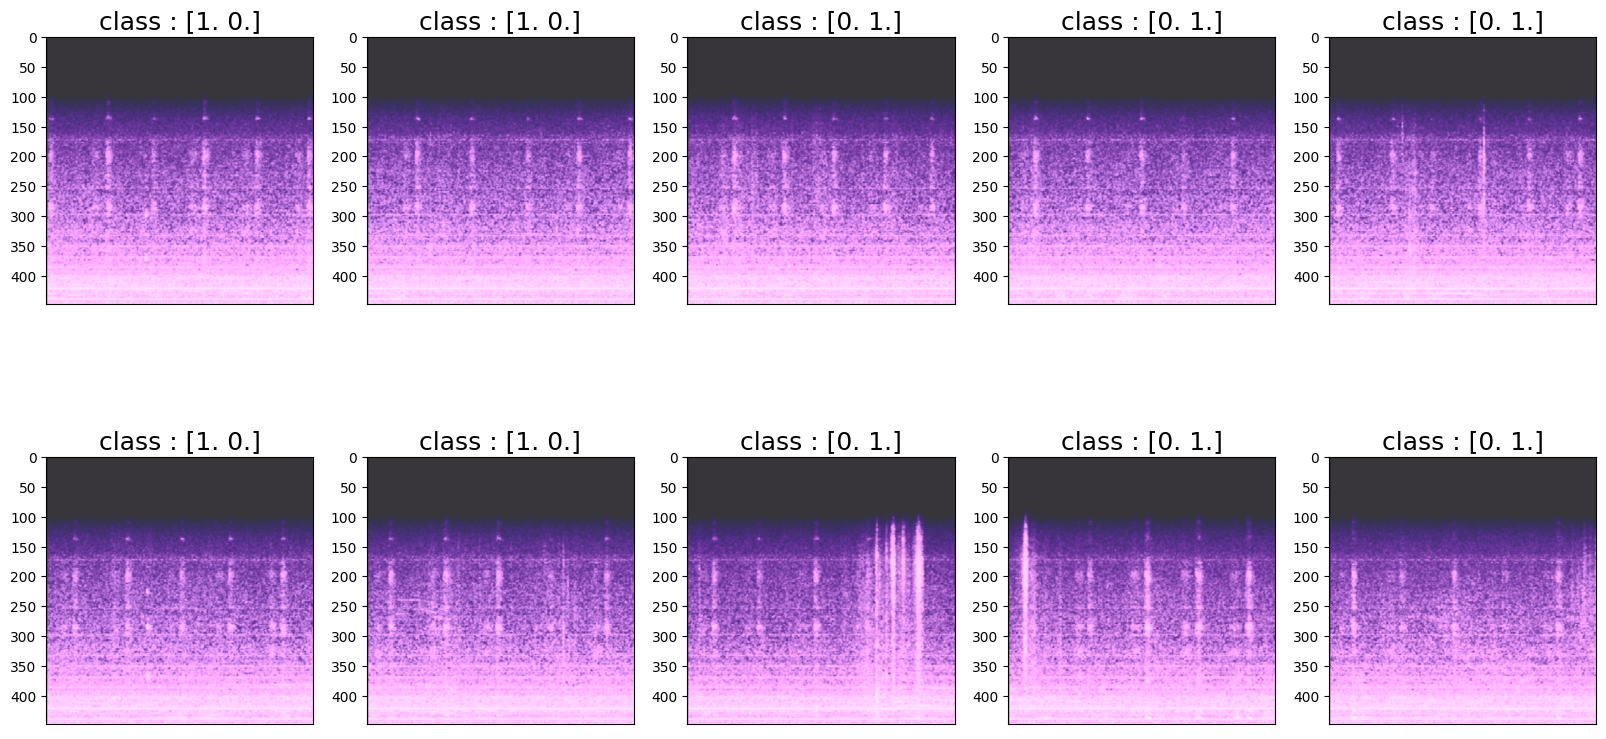

In [6]:
plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)                                    
    plt.title("class : " + str(Y_train[i]), 
               fontsize=18)                                        
    plt.xticks([])                                                
    ax.imshow(X_train[0][i])    

In [7]:
# import tensorflow as tf
# from tensorflow.core.protobuf import rewriter_config_pb2
# from tensorflow.keras.backend import set_session
# tf.keras.backend.clear_session()  # For easy reset of notebook state.

# config_proto = tf.ConfigProto()
# off = rewriter_config_pb2.RewriterConfig.OFF
# config_proto.graph_options.rewrite_options.arithmetic_optimization = off
# session = tf.Session(config=config_proto)
# set_session(session)

In [1]:
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

2023-02-06 11:08:18.383708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 11:08:18.544949: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-06 11:08:18.584198: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 11:08:19.355943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def my_model(timesteps, img_height, img_width, img_color_channels, num_classes):
    
    input_batch = Input(shape = (timesteps, img_height, img_width, img_color_channels))
    
    
    cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(input_batch)
    cnn_network = TimeDistributed(Conv2D(4, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'))(cnn_network)
    cnn_network = TimeDistributed(BatchNormalization())(cnn_network)
    cnn_network = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same', strides=(4,4)))(cnn_network)
    
    cnn_network = TimeDistributed(Flatten())(cnn_network)
   
    
    lstm_network = LSTM(12, return_sequences=False, dropout=0.05, recurrent_dropout=0.05)(cnn_network)
    lstm_network = Dense(4,activation='relu')(lstm_network)
    lstm_network = Dropout(0.1)(lstm_network)
    lstm_network = Dense(2,activation='relu')(lstm_network)
    lstm_network = Dropout(0.1)(lstm_network)
    lstm_network = Dense(num_classes, activation='softmax')(lstm_network)
    
    
    full_network = Model(input_batch, lstm_network)
    return full_network

In [3]:
model = my_model(timesteps = 10,
                 img_height = 448,
                 img_width = 448,
                 img_color_channels = 3,
                 num_classes = 2)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

2023-02-06 11:08:29.922791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 11:08:32.654476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78963 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:12:00.0, compute capability: 8.0
2023-02-06 11:08:32.655799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78969 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:13:00.0, compute capability: 8.0
2023-02-06 11:08:32.657076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/r

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 448, 448, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 448, 448, 4)  112       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 448, 448, 4)  148       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 448, 448, 4)  16        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 112, 112, 4)  0     

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = 10
num_epoch = 1200
start_time = time.perf_counter()
model_history = model.fit(x = X_train,
                    y = Y_train, 
                    batch_size = batch_sizes,
                    epochs = num_epoch,
                    validation_data = (X_valid, Y_valid),
                    validation_batch_size = batch_sizes,
                    callbacks = [EarlyStopping(monitor = 'val_loss',
                                               patience = 60,
                                               verbose = 1)]
                   )
print(f'Total time: {time.perf_counter() - start_time} sec')

Epoch 1/1200


2023-02-04 13:05:03.526040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-02-04 13:05:06.435685: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


142/142 [==============================] - 47s 264ms/step - loss: 0.6935 - accuracy: 0.5247 - val_loss: 0.6932 - val_accuracy: 0.4111
Epoch 2/1200
142/142 [==============================] - 37s 258ms/step - loss: 0.6930 - accuracy: 0.5551 - val_loss: 0.6939 - val_accuracy: 0.4278
Epoch 3/1200
142/142 [==============================] - 35s 249ms/step - loss: 0.6931 - accuracy: 0.5268 - val_loss: 0.6934 - val_accuracy: 0.4556
Epoch 4/1200
142/142 [==============================] - 33s 232ms/step - loss: 0.6927 - accuracy: 0.5678 - val_loss: 0.6943 - val_accuracy: 0.4611
Epoch 5/1200
142/142 [==============================] - 36s 256ms/step - loss: 0.6925 - accuracy: 0.5487 - val_loss: 0.6930 - val_accuracy: 0.5222
Epoch 6/1200
142/142 [==============================] - 36s 257ms/step - loss: 0.6917 - accuracy: 0.5734 - val_loss: 0.6927 - val_accuracy: 0.5611
Epoch 7/1200
142/142 [==============================] - 33s 236ms/step - loss: 0.6914 - accuracy: 0.5664 - val_loss: 0.6922 - val_a

142/142 [==============================] - 31s 216ms/step - loss: 0.5559 - accuracy: 0.8347 - val_loss: 0.5525 - val_accuracy: 0.8556
Epoch 112/1200
142/142 [==============================] - 31s 218ms/step - loss: 0.5544 - accuracy: 0.8178 - val_loss: 0.5459 - val_accuracy: 0.8667
Epoch 113/1200
142/142 [==============================] - 31s 220ms/step - loss: 0.5515 - accuracy: 0.8242 - val_loss: 0.5466 - val_accuracy: 0.8500
Epoch 114/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.5553 - accuracy: 0.8185 - val_loss: 0.5452 - val_accuracy: 0.8611
Epoch 115/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.5455 - accuracy: 0.8298 - val_loss: 0.5457 - val_accuracy: 0.8611
Epoch 116/1200
142/142 [==============================] - 30s 211ms/step - loss: 0.5484 - accuracy: 0.8270 - val_loss: 0.5389 - val_accuracy: 0.8778
Epoch 117/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.5420 - accuracy: 0.8404 - val_loss: 0.

142/142 [==============================] - 31s 218ms/step - loss: 0.4911 - accuracy: 0.8531 - val_loss: 0.4923 - val_accuracy: 0.8722
Epoch 167/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.4897 - accuracy: 0.8609 - val_loss: 0.4872 - val_accuracy: 0.8778
Epoch 168/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.4824 - accuracy: 0.8708 - val_loss: 0.4788 - val_accuracy: 0.8889
Epoch 169/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.4989 - accuracy: 0.8460 - val_loss: 0.4813 - val_accuracy: 0.8889
Epoch 170/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.4890 - accuracy: 0.8573 - val_loss: 0.4811 - val_accuracy: 0.8722
Epoch 171/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.4926 - accuracy: 0.8545 - val_loss: 0.4790 - val_accuracy: 0.8778
Epoch 172/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.4831 - accuracy: 0.8637 - val_loss: 0.

142/142 [==============================] - 31s 218ms/step - loss: 0.4525 - accuracy: 0.8665 - val_loss: 0.4390 - val_accuracy: 0.9000
Epoch 222/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.4434 - accuracy: 0.8701 - val_loss: 0.4365 - val_accuracy: 0.9000
Epoch 223/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.4459 - accuracy: 0.8750 - val_loss: 0.4369 - val_accuracy: 0.8944
Epoch 224/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.4481 - accuracy: 0.8750 - val_loss: 0.4369 - val_accuracy: 0.9056
Epoch 225/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.4506 - accuracy: 0.8679 - val_loss: 0.4354 - val_accuracy: 0.8944
Epoch 226/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.4412 - accuracy: 0.8785 - val_loss: 0.4396 - val_accuracy: 0.8944
Epoch 227/1200
142/142 [==============================] - 31s 219ms/step - loss: 0.4381 - accuracy: 0.8814 - val_loss: 0.

142/142 [==============================] - 30s 211ms/step - loss: 0.4259 - accuracy: 0.8672 - val_loss: 0.3938 - val_accuracy: 0.9056
Epoch 277/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.4144 - accuracy: 0.8799 - val_loss: 0.3967 - val_accuracy: 0.9111
Epoch 278/1200
142/142 [==============================] - 30s 209ms/step - loss: 0.4246 - accuracy: 0.8715 - val_loss: 0.3955 - val_accuracy: 0.9000
Epoch 279/1200
142/142 [==============================] - 30s 211ms/step - loss: 0.4086 - accuracy: 0.8828 - val_loss: 0.3943 - val_accuracy: 0.9000
Epoch 280/1200
142/142 [==============================] - 30s 215ms/step - loss: 0.4057 - accuracy: 0.8870 - val_loss: 0.3988 - val_accuracy: 0.9000
Epoch 281/1200
142/142 [==============================] - 30s 210ms/step - loss: 0.4197 - accuracy: 0.8736 - val_loss: 0.3940 - val_accuracy: 0.9000
Epoch 282/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.4108 - accuracy: 0.8821 - val_loss: 0.

142/142 [==============================] - 30s 215ms/step - loss: 0.3804 - accuracy: 0.8898 - val_loss: 0.3716 - val_accuracy: 0.9222
Epoch 332/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3865 - accuracy: 0.8842 - val_loss: 0.3649 - val_accuracy: 0.9167
Epoch 333/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3967 - accuracy: 0.8757 - val_loss: 0.3639 - val_accuracy: 0.9167
Epoch 334/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.3864 - accuracy: 0.8863 - val_loss: 0.3674 - val_accuracy: 0.9222
Epoch 335/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.3971 - accuracy: 0.8785 - val_loss: 0.3613 - val_accuracy: 0.9167
Epoch 336/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.3787 - accuracy: 0.8870 - val_loss: 0.3612 - val_accuracy: 0.9333
Epoch 337/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.3797 - accuracy: 0.8948 - val_loss: 0.

142/142 [==============================] - 31s 218ms/step - loss: 0.3405 - accuracy: 0.9096 - val_loss: 0.3525 - val_accuracy: 0.9333
Epoch 387/1200
142/142 [==============================] - 32s 223ms/step - loss: 0.3552 - accuracy: 0.8962 - val_loss: 0.3515 - val_accuracy: 0.9111
Epoch 388/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.3527 - accuracy: 0.8969 - val_loss: 0.3517 - val_accuracy: 0.9167
Epoch 389/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.3466 - accuracy: 0.9032 - val_loss: 0.3493 - val_accuracy: 0.9278
Epoch 390/1200
142/142 [==============================] - 30s 215ms/step - loss: 0.3728 - accuracy: 0.8828 - val_loss: 0.3496 - val_accuracy: 0.9167
Epoch 391/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.3479 - accuracy: 0.9032 - val_loss: 0.3488 - val_accuracy: 0.9222
Epoch 392/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.3551 - accuracy: 0.8927 - val_loss: 0.

142/142 [==============================] - 30s 214ms/step - loss: 0.3493 - accuracy: 0.8912 - val_loss: 0.3304 - val_accuracy: 0.9278
Epoch 442/1200
142/142 [==============================] - 31s 222ms/step - loss: 0.3337 - accuracy: 0.9068 - val_loss: 0.3257 - val_accuracy: 0.9278
Epoch 443/1200
142/142 [==============================] - 31s 221ms/step - loss: 0.3229 - accuracy: 0.9089 - val_loss: 0.3416 - val_accuracy: 0.9056
Epoch 444/1200
142/142 [==============================] - 32s 228ms/step - loss: 0.3419 - accuracy: 0.8919 - val_loss: 0.3513 - val_accuracy: 0.9056
Epoch 445/1200
142/142 [==============================] - 32s 224ms/step - loss: 0.3493 - accuracy: 0.8898 - val_loss: 0.3343 - val_accuracy: 0.9167
Epoch 446/1200
142/142 [==============================] - 31s 221ms/step - loss: 0.3327 - accuracy: 0.8997 - val_loss: 0.3277 - val_accuracy: 0.9167
Epoch 447/1200
142/142 [==============================] - 32s 223ms/step - loss: 0.3422 - accuracy: 0.8912 - val_loss: 0.

142/142 [==============================] - 32s 224ms/step - loss: 0.3223 - accuracy: 0.8997 - val_loss: 0.3323 - val_accuracy: 0.9167
Epoch 497/1200
142/142 [==============================] - 30s 211ms/step - loss: 0.3192 - accuracy: 0.9040 - val_loss: 0.3327 - val_accuracy: 0.9000
Epoch 498/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.3168 - accuracy: 0.9047 - val_loss: 0.3243 - val_accuracy: 0.9167
Epoch 499/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.3309 - accuracy: 0.8912 - val_loss: 0.3314 - val_accuracy: 0.9111
Epoch 500/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3270 - accuracy: 0.8934 - val_loss: 0.3279 - val_accuracy: 0.9111
Epoch 501/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3150 - accuracy: 0.9018 - val_loss: 0.3300 - val_accuracy: 0.9111
Epoch 502/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3434 - accuracy: 0.8799 - val_loss: 0.

142/142 [==============================] - 30s 214ms/step - loss: 0.3145 - accuracy: 0.9011 - val_loss: 0.3293 - val_accuracy: 0.9111
Epoch 552/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.2991 - accuracy: 0.9082 - val_loss: 0.3260 - val_accuracy: 0.9167
Epoch 553/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.2962 - accuracy: 0.9124 - val_loss: 0.3122 - val_accuracy: 0.9111
Epoch 554/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.3072 - accuracy: 0.9032 - val_loss: 0.3224 - val_accuracy: 0.8944
Epoch 555/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.3088 - accuracy: 0.9040 - val_loss: 0.3147 - val_accuracy: 0.9111
Epoch 556/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.2925 - accuracy: 0.9145 - val_loss: 0.3200 - val_accuracy: 0.9111
Epoch 557/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.3143 - accuracy: 0.9004 - val_loss: 0.

142/142 [==============================] - 30s 214ms/step - loss: 0.2872 - accuracy: 0.9138 - val_loss: 0.2914 - val_accuracy: 0.9222
Epoch 607/1200
142/142 [==============================] - 30s 212ms/step - loss: 0.2865 - accuracy: 0.9131 - val_loss: 0.3189 - val_accuracy: 0.8944
Epoch 608/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.2844 - accuracy: 0.9138 - val_loss: 0.3169 - val_accuracy: 0.9056
Epoch 609/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.2798 - accuracy: 0.9181 - val_loss: 0.3262 - val_accuracy: 0.9000
Epoch 610/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.2910 - accuracy: 0.9103 - val_loss: 0.3057 - val_accuracy: 0.9056
Epoch 611/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.2782 - accuracy: 0.9167 - val_loss: 0.3061 - val_accuracy: 0.9111
Epoch 612/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.2845 - accuracy: 0.9124 - val_loss: 0.

142/142 [==============================] - 31s 218ms/step - loss: 0.2698 - accuracy: 0.9174 - val_loss: 0.3137 - val_accuracy: 0.9056
Epoch 662/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.2715 - accuracy: 0.9209 - val_loss: 0.3086 - val_accuracy: 0.9000
Epoch 663/1200
142/142 [==============================] - 31s 221ms/step - loss: 0.2765 - accuracy: 0.9138 - val_loss: 0.3053 - val_accuracy: 0.9056
Epoch 664/1200
142/142 [==============================] - 33s 231ms/step - loss: 0.2748 - accuracy: 0.9124 - val_loss: 0.3000 - val_accuracy: 0.9278
Epoch 665/1200
142/142 [==============================] - 32s 225ms/step - loss: 0.2775 - accuracy: 0.9082 - val_loss: 0.3091 - val_accuracy: 0.9111
Epoch 666/1200
142/142 [==============================] - 32s 225ms/step - loss: 0.2711 - accuracy: 0.9188 - val_loss: 0.3072 - val_accuracy: 0.9111
Epoch 667/1200
142/142 [==============================] - 32s 222ms/step - loss: 0.2609 - accuracy: 0.9251 - val_loss: 0.

142/142 [==============================] - 32s 227ms/step - loss: 0.2693 - accuracy: 0.9124 - val_loss: 0.2998 - val_accuracy: 0.9167
Epoch 717/1200
142/142 [==============================] - 32s 223ms/step - loss: 0.2705 - accuracy: 0.9153 - val_loss: 0.2970 - val_accuracy: 0.9167
Epoch 718/1200
142/142 [==============================] - 32s 225ms/step - loss: 0.2640 - accuracy: 0.9188 - val_loss: 0.3047 - val_accuracy: 0.8944
Epoch 719/1200
142/142 [==============================] - 31s 219ms/step - loss: 0.2667 - accuracy: 0.9181 - val_loss: 0.2889 - val_accuracy: 0.9222
Epoch 720/1200
142/142 [==============================] - 31s 216ms/step - loss: 0.2617 - accuracy: 0.9202 - val_loss: 0.2980 - val_accuracy: 0.9222
Epoch 721/1200
142/142 [==============================] - 31s 217ms/step - loss: 0.2762 - accuracy: 0.9110 - val_loss: 0.2807 - val_accuracy: 0.9222
Epoch 722/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.2581 - accuracy: 0.9202 - val_loss: 0.

142/142 [==============================] - 31s 219ms/step - loss: 0.2404 - accuracy: 0.9301 - val_loss: 0.2996 - val_accuracy: 0.9000
Epoch 772/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.2614 - accuracy: 0.9195 - val_loss: 0.2898 - val_accuracy: 0.9222
Epoch 773/1200
142/142 [==============================] - 31s 219ms/step - loss: 0.2540 - accuracy: 0.9237 - val_loss: 0.2893 - val_accuracy: 0.9167
Epoch 774/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.2720 - accuracy: 0.9124 - val_loss: 0.3087 - val_accuracy: 0.9056
Epoch 775/1200
142/142 [==============================] - 30s 213ms/step - loss: 0.2490 - accuracy: 0.9287 - val_loss: 0.2812 - val_accuracy: 0.9167
Epoch 776/1200
142/142 [==============================] - 30s 214ms/step - loss: 0.2438 - accuracy: 0.9273 - val_loss: 0.2810 - val_accuracy: 0.9111
Epoch 777/1200
142/142 [==============================] - 31s 215ms/step - loss: 0.2691 - accuracy: 0.9117 - val_loss: 0.

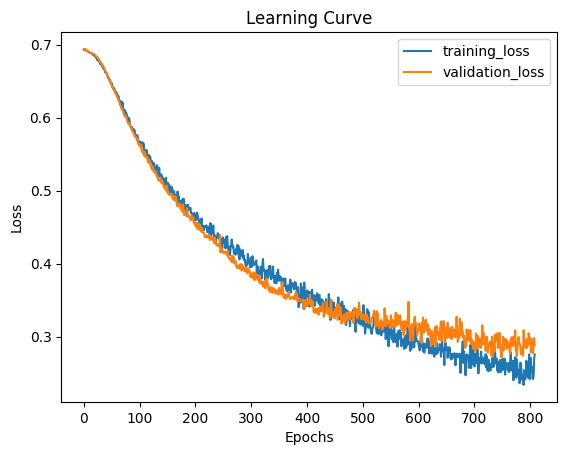

In [12]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

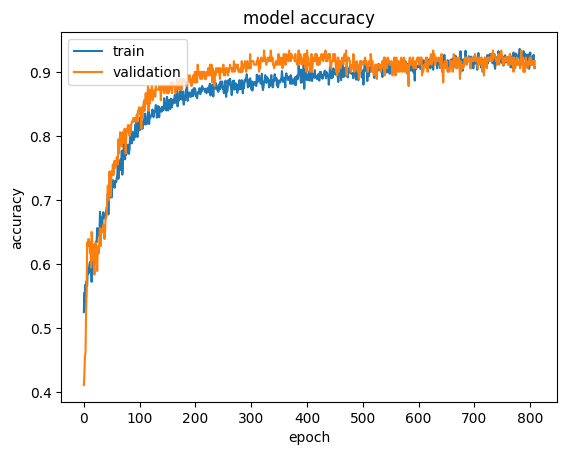

In [13]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
test_pred = model.evaluate(X_test, Y_test, batch_size=10)
print("test loss, test acc:", test_pred)

24/24 [==============================] - 2s 77ms/step - loss: 0.2972 - accuracy: 0.9042
test loss, test acc: [0.29723402857780457, 0.9041666388511658]


In [15]:
pred = model.predict(X_test, batch_size=10)
print("predictions: ")
print(pred)
print("answer : ")
print(Y_test)

24/24 [==============================] - 3s 77ms/step
predictions: 
[[8.0795395e-01 1.9204603e-01]
 [7.4957852e-04 9.9925035e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [7.7151711e-04 9.9922848e-01]
 [2.1011641e-03 9.9789882e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [1.5838103e-01 8.4161896e-01]
 [8.0795395e-01 1.9204603e-01]
 [1.0749784e-03 9.9892503e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [6.1694131e-04 9.9938309e-01]
 [8.0795395e-01 1.9204603e-01]
 [5.5367401e-04 9.9944633e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [5.6557231e-02 9.4344276e-01]
 [4.8992801e-02 9.5100719e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [8.0795395e-01 1.9204603e-01]
 [

ROC_AUC_Score: 0.9233862433862434



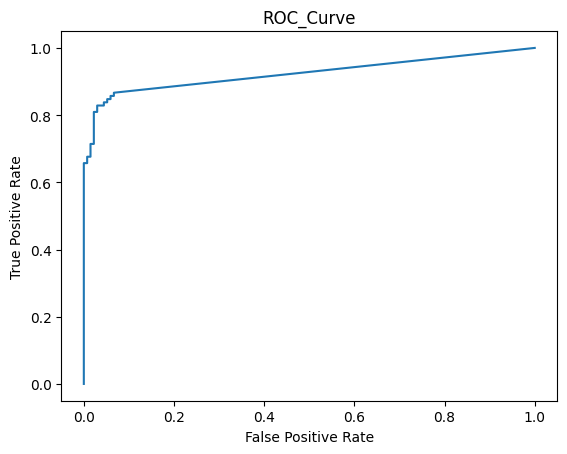

In [16]:
import sklearn.metrics

print(f'ROC_AUC_Score: {sklearn.metrics.roc_auc_score(Y_test[:,1], pred[:,1])}')
print()
fpr, tpr, _ = sklearn.metrics.roc_curve(Y_test[:,1], pred[:,1])
plt.plot(fpr, tpr)
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [17]:
pred = pred.argmax(-1)
print('Confusion Matrix: ')
print(sklearn.metrics.confusion_matrix(Y_test.argmax(-1), pred))
print()
print(f'Cohen_Kappa_Score: {sklearn.metrics.cohen_kappa_score(Y_test.argmax(-1), pred)}')

Confusion Matrix: 
[[129   6]
 [ 17  88]]

Cohen_Kappa_Score: 0.8029978586723769


In [18]:
# model.save("lstm.h5(1)")